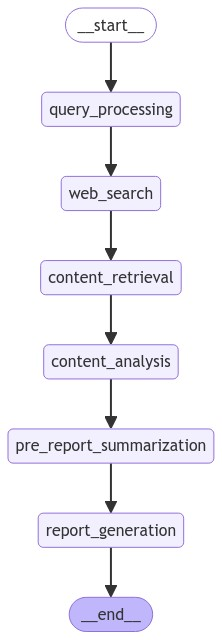

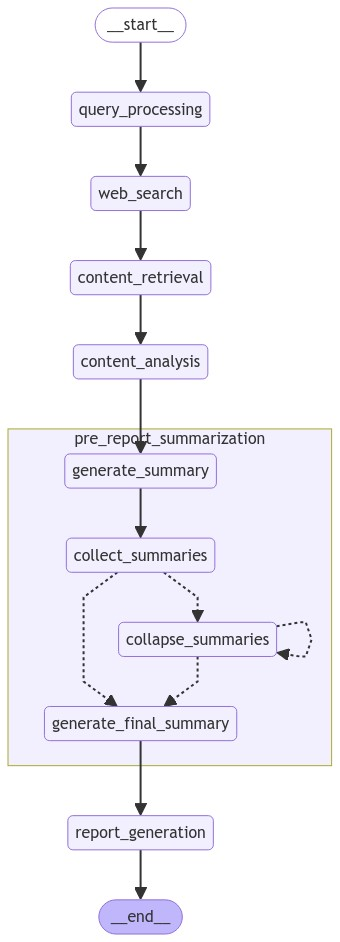

2024-08-29 21:58:00,093 - INFO - Starting step: process_query
2024-08-29 21:58:00,970 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-08-29 21:58:02,096 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-08-29 21:58:02,114 - INFO - Finished step: process_query (Time taken: 2.02 seconds)
2024-08-29 21:58:02,125 - INFO - Starting step: perform_web_search_node
search_query = 'What are the available open-source AI code assistants? open-source AI code assistants available AI programming assistants AI assistants open-source machine learning frameworks open-source'
2024-08-29 21:58:09,387 - INFO - Finished step: perform_web_search_node (Time taken: 7.26 seconds)
2024-08-29 21:58:09,406 - INFO - Starting step: retrieve_content
2024-08-29 21:58:11,720 - INFO - Finished step: retrieve_content (Time taken: 2.31 seconds)
2024-08-29 21:58:11,727 - INFO - Starting step: analyze_content
2024-08-29 21:58:11,736 - 

In [1]:
import os

from typing import List
import sqlite3
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver
from reportgen_agent.core.state import ReportGenState
from reportgen_agent.nodes.query_processing import process_query
from reportgen_agent.nodes.web_search import perform_web_search_node
from reportgen_agent.nodes.content_retrieval import retrieve_content
from reportgen_agent.nodes.content_analysis import analyze_content
from reportgen_agent.nodes.report_generation import generate_report
from reportgen_agent.utils.storage_utils import create_run_directory
from reportgen_agent.core.graph import create_pre_report_summarization_graph
from reportgen_agent.utils import wrap_node_with_logging
import sys

sys.path.append("../")


def main(query: str, search_results: List[str], analyzed_content=List[str]):
    run_dir, run_id = create_run_directory()

    initial_state = ReportGenState(
        query=query,
        keywords=[],
        expanded_concepts=[],
        search_results=search_results,
        retrieved_content=[],
        filtered_content=[],
        analyzed_content=analyzed_content,
        markdown_report="",
    )

    graph = StateGraph(ReportGenState)
    pre_report_summarization_graph = create_pre_report_summarization_graph(
        run_dir + "/pre_report_summarization"
    )

    ###########
    ## NODES ##
    ###########
    graph.add_node("query_processing",
                   wrap_node_with_logging(process_query, run_dir))
    graph.add_node(
        "web_search", wrap_node_with_logging(perform_web_search_node, run_dir)
    )
    graph.add_node(
        "content_retrieval",
        wrap_node_with_logging(retrieve_content, run_dir),
    )
    graph.add_node("content_analysis", wrap_node_with_logging(
        analyze_content, run_dir))
    graph.add_node(
        "pre_report_summarization",
        pre_report_summarization_graph.compile(),
    )
    graph.add_node(
        "report_generation", wrap_node_with_logging(generate_report, run_dir)
    )

    ###########
    ## EDGES ##
    ###########
    graph.add_edge("query_processing", "web_search")
    graph.add_edge("web_search", "content_retrieval")
    graph.add_edge("content_retrieval", "content_analysis")
    graph.add_edge("content_analysis", "pre_report_summarization")
    graph.add_edge("pre_report_summarization", "report_generation")

    graph.set_entry_point("query_processing")
    graph.add_edge("report_generation", END)

    conn = sqlite3.connect("../data/checkpoints.sqlite",
                           check_same_thread=False)
    memory = SqliteSaver(conn)

    compiled_graph = graph.compile(checkpointer=memory)

    from IPython.display import Image, display
    from langchain_core.runnables.graph import MermaidDrawMethod

    display(
        Image(
            compiled_graph.get_graph().draw_mermaid_png(
                output_file_path="agent_graph.png",
                draw_method=MermaidDrawMethod.API,
            )
        )
    )
    display(
        Image(
            compiled_graph.get_graph(xray=1).draw_mermaid_png(
                output_file_path="agent_graph-detailed.png",
                draw_method=MermaidDrawMethod.API,
            )
        )
    )
    # print(compiled_graph.get_graph().draw_mermaid())

    # Execute the graph with the initial state
    result = compiled_graph.invoke(
        initial_state,
        {"configurable": {"thread_id": "1"}},
    )

    # # Print the final output (e.g., the generated Markdown report)
    print("Generated Report:")
    print(result["markdown_report"])

    report_file_path = os.path.join(run_dir, "generated_report.md")
    with open(report_file_path, "w") as f:
        f.write(result["markdown_report"])
    print(f"Report saved to: {report_file_path}")


main(
    query="What are the available open-source AI code assistants?",
    search_results=[],
    analyzed_content=[],
)